In [1]:
from sklearn.preprocessing import StandardScaler
from common.classification import plot_kernel_density_estimator, \
    compute_bandwidth_for_kernel_density_estimator, perform_classification_using_kernel_density_estimator, \
    decision_tree_full_classification_test, k_neighbours_full_classification_test, \
    split_dataset_into_training_and_testing_parts
from sklearn.neighbors import KernelDensity
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.figsize'] = [7, 7]

### Dataset loading
Please note that the `_preprocessed` file is required. To use this notebook
properly, please execute the preprocessing one first to generate proper dataset
file.

In [2]:
# load dataset from file, create backup with all columns
data = pd.read_excel("../data/games_sales_2016_preprocessed.xlsx", index_col=0)
data_backup = data.copy(deep=True)

## User_Score classification - 2 classes
Two classes will be used: user score higher and lower than 7.5.
Classification will be performed using Critic_Score and Year_of_Release.

### Data preparation

Number of entries in each cluster:
1    3727
0    3218
Name: cluster, dtype: int64


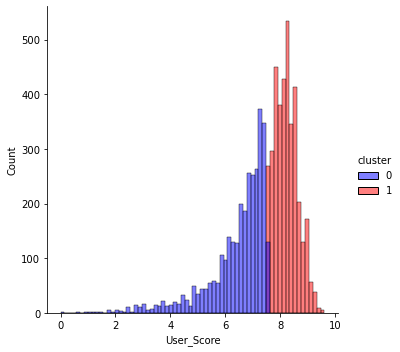

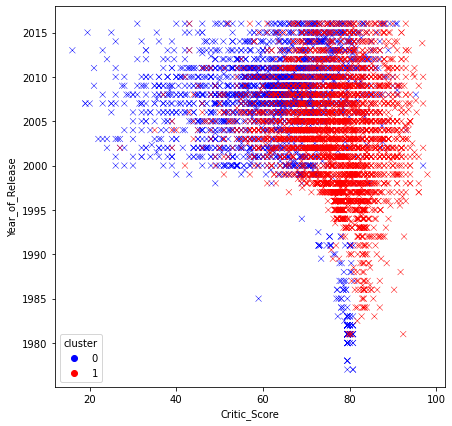

In [3]:
# filter used columns
used_columns = ["Critic_Score", "Year_of_Release", "User_Score"]
data = data_backup.filter(items=["Name", *used_columns])

# group by game name
data = data.groupby("Name").agg({"Critic_Score": np.mean, "User_Score": np.mean, "Year_of_Release": np.mean})\
    .reset_index().sort_values(by="User_Score").filter(items=used_columns)

# create artificial clusters - classes
data["cluster"] = 0
data.loc[data["User_Score"] > 7.5, "cluster"] = 1

# print clusters sizes
print("Number of entries in each cluster:\n{}".format(data["cluster"].value_counts()))

# display density plot with classes
palette = ["blue", "red"]
sns.displot(data, x="User_Score", hue="cluster", palette=palette)
plt.show()

# display scatter plot with classes
sns.scatterplot(data=data, x="Critic_Score", y="Year_of_Release", hue="cluster", palette=palette, marker='x')
plt.show()

# standardize data
standardization = StandardScaler().fit(data[used_columns])
data[used_columns] = standardization.transform(data[used_columns])

# drop column with User_Score - it should not be used for the classification
data = data.drop(["User_Score"], axis=1)

### Split the dataset into training and testing parts for further studies

In [4]:
training_columns = ["Critic_Score", "Year_of_Release"]
training_data, testing_data = split_dataset_into_training_and_testing_parts(data, training_columns, 0.2)

### Perform classification using KNN

K = 1 - test data score: 0.7177825773938085, training data score: 0.8597912167026638
K = 2 - test data score: 0.7098632109431245, training data score: 0.8106551475881929
K = 3 - test data score: 0.7530597552195825, training data score: 0.8347732181425486
K = 4 - test data score: 0.755939524838013, training data score: 0.818394528437725
K = 5 - test data score: 0.7645788336933045, training data score: 0.8209143268538517
K = 6 - test data score: 0.7552195824334054, training data score: 0.8111951043916487
K = 7 - test data score: 0.7645788336933045, training data score: 0.8138948884089273
K = 8 - test data score: 0.7681785457163427, training data score: 0.8106551475881929
K = 9 - test data score: 0.769618430525558, training data score: 0.8119150467962563
K = 10 - test data score: 0.7703383729301656, training data score: 0.8077753779697624
K = 11 - test data score: 0.7724982001439885, training data score: 0.808675305975522
K = 12 - test data score: 0.7710583153347732, training data score: 

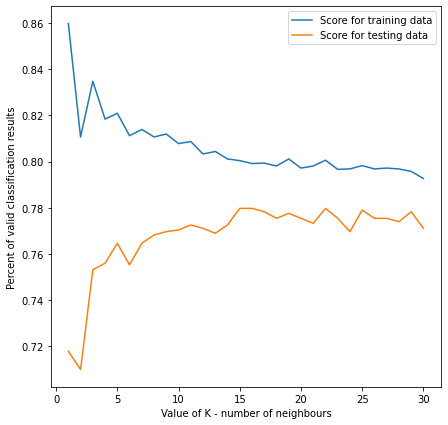

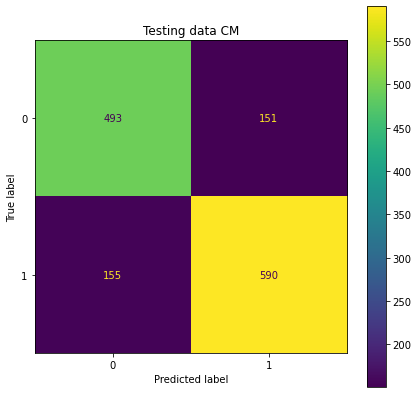

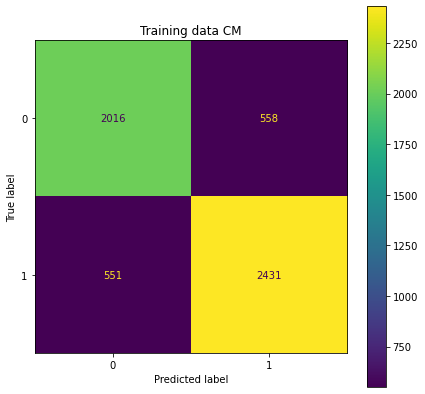

In [5]:
k_neighbours_full_classification_test(training_data, testing_data, training_columns)

### Perform classification using decision tree

Max depth = 1 - test data score: 0.7228221742260619, training data score: 0.7311015118790497
Max depth = 2 - test data score: 0.7228221742260619, training data score: 0.7311015118790497
Max depth = 3 - test data score: 0.7566594672426206, training data score: 0.7645788336933045
Max depth = 4 - test data score: 0.7681785457163427, training data score: 0.771598272138229
Max depth = 5 - test data score: 0.7796976241900648, training data score: 0.7904967602591793
Max depth = 6 - test data score: 0.7724982001439885, training data score: 0.7976961843052556
Max depth = 7 - test data score: 0.7732181425485961, training data score: 0.8014758819294456
Max depth = 8 - test data score: 0.7732181425485961, training data score: 0.8097552195824333
Max depth = 9 - test data score: 0.7746580273578114, training data score: 0.8201943844492441
Max depth = 10 - test data score: 0.7732181425485961, training data score: 0.8333333333333334

Using decision tree with max depth=3 to perform in-depth tests:
Accur

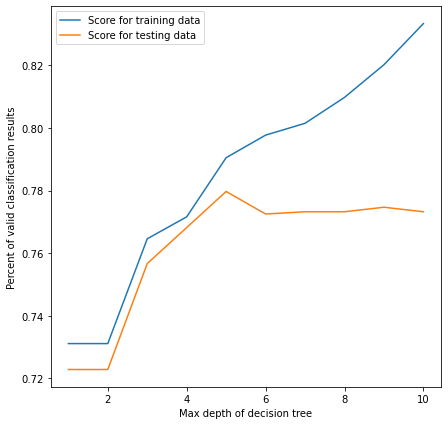

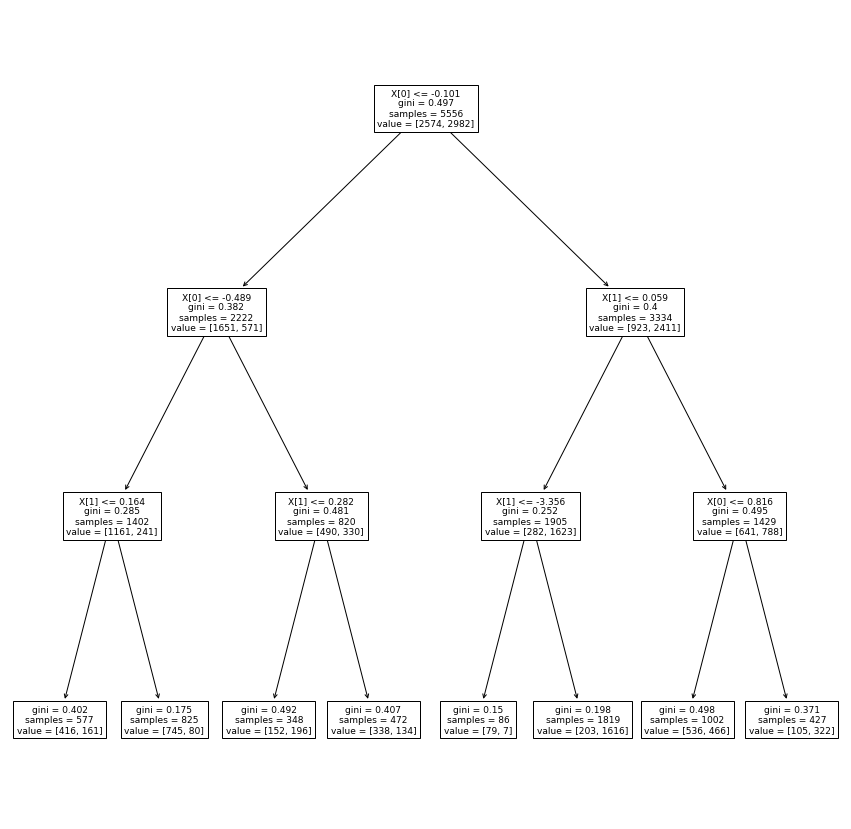

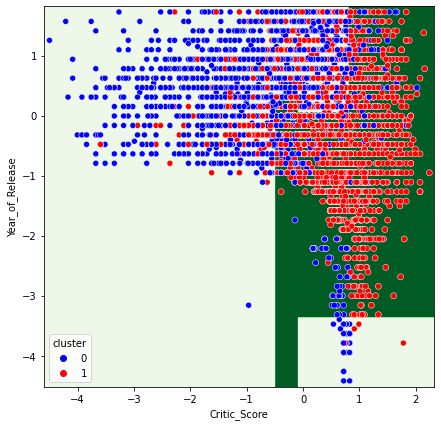

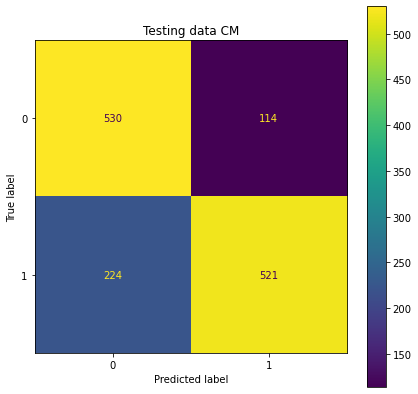

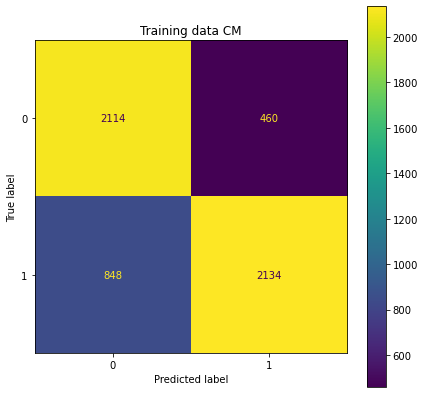

In [6]:
decision_tree_full_classification_test(training_data, testing_data, training_columns, palette)

### Perform classification using kernel density estimators

Bandwidth for class 0: 0.1384886371393873
Bandwidth for class 1: 0.1384886371393873
Total number of training samples: 5556
Number of training samples in class 0: 2574
Number of training samples in class 1: 2982
KDE classification - training data:
Classification accuracy: 0.7922966162706984
KDE classification - testing data:
Classification accuracy: 0.7818574514038877


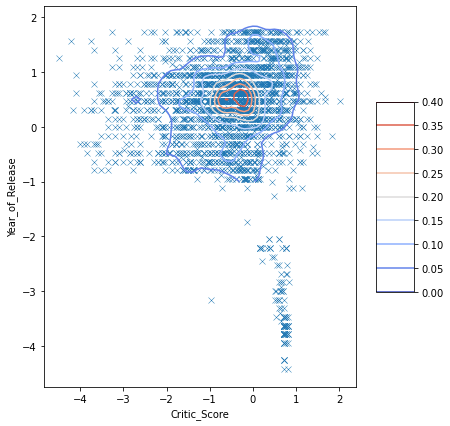

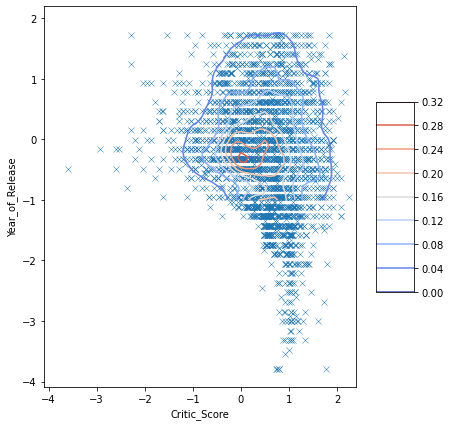

0.7818574514038877

In [7]:
# use cross-validation to get proper bandwidths, plot KDEs
# they should be about: 0.145 and 0.138
bandwidths_for_classes = []
for cl in range(0, 2):
    bandwidth_for_given_class = compute_bandwidth_for_kernel_density_estimator(training_data, training_columns, cl)
    bandwidths_for_classes.append(bandwidth_for_given_class)
    print("Bandwidth for class {}: {}".format(cl, bandwidth_for_given_class))
    plot_kernel_density_estimator(training_data, training_columns, cl, bandwidth_for_given_class)

# get members count for each class
cl0_count = training_data[training_data["cluster"] == 0].shape[0]
cl1_count = training_data[training_data["cluster"] == 1].shape[0]

# prepare KDE objects
tr_data_cl0 = training_data[training_data["cluster"] == 0]
kde_cl0 = KernelDensity(bandwidth=bandwidths_for_classes[0], kernel="gaussian").fit(tr_data_cl0[training_columns])
tr_data_cl1 = training_data[training_data["cluster"] == 1]
kde_cl1 = KernelDensity(bandwidth=bandwidths_for_classes[1], kernel="gaussian").fit(tr_data_cl1[training_columns])

# print information about training data
print("Total number of training samples: {}".format(training_data.shape[0]))
print("Number of training samples in class 0: {}".format(cl0_count))
print("Number of training samples in class 1: {}".format(cl1_count))

# perform classification, display accuracy
print("KDE classification - training data:")
perform_classification_using_kernel_density_estimator(training_data, training_columns, [cl0_count, cl1_count], [kde_cl0, kde_cl1])
print("KDE classification - testing data:")
perform_classification_using_kernel_density_estimator(testing_data, training_columns, [cl0_count, cl1_count], [kde_cl0, kde_cl1])

## Global_Sales classification - 2 classes
Two classes will be used: global sales higher and lower than 1 million.
Classification will be performed using Critic_Score and Year_of_Release.

### Data preparation

Number of entries in each cluster:
0    4952
1    1993
Name: cluster, dtype: int64


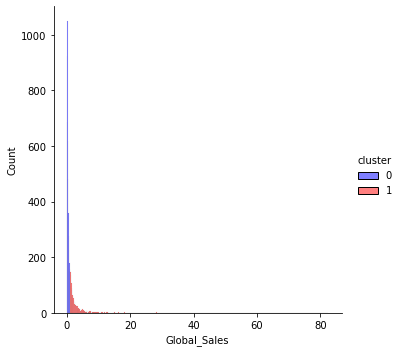

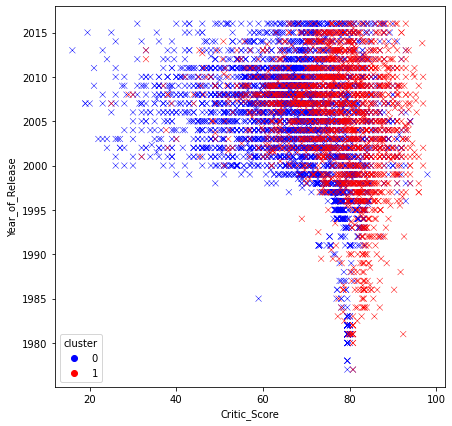

In [8]:
# filter used columns
used_columns = ["Critic_Score", "Year_of_Release", "Global_Sales"]
data = data_backup.filter(items=["Name", *used_columns])

# group by game name
data = data.groupby("Name").agg({"Critic_Score": np.mean, "Global_Sales": np.sum, "Year_of_Release": np.mean})\
    .reset_index().sort_values(by="Global_Sales").filter(items=used_columns)

# create artificial clusters - classes
data["cluster"] = 0
data.loc[data["Global_Sales"] > 1, "cluster"] = 1

# print clusters sizes
print("Number of entries in each cluster:\n{}".format(data["cluster"].value_counts()))

# display density plot with classes
palette = ["blue", "red"]
sns.displot(data, x="Global_Sales", hue="cluster", palette=palette)
plt.show()

# display scatter plot with classes
sns.scatterplot(data=data, x="Critic_Score", y="Year_of_Release", hue="cluster", palette=palette, marker='x')
plt.show()

# standardize data
standardization = StandardScaler().fit(data[used_columns])
data[used_columns] = standardization.transform(data[used_columns])

# drop column with Global_Sales - it should not be used for the classification
data = data.drop(["Global_Sales"], axis=1)

### Split the dataset into training and testing parts for further studies

In [9]:
training_columns = ["Critic_Score", "Year_of_Release"]
training_data, testing_data = split_dataset_into_training_and_testing_parts(data, training_columns, 0.2)

### Perform classification using KNN

K = 1 - test data score: 0.7257019438444925, training data score: 0.8853491720662346
K = 2 - test data score: 0.7386609071274298, training data score: 0.8245140388768899
K = 3 - test data score: 0.7444204463642908, training data score: 0.8327933765298776
K = 4 - test data score: 0.7494600431965442, training data score: 0.8117350611951044
K = 5 - test data score: 0.7422606191504679, training data score: 0.8135349172066235
K = 6 - test data score: 0.7444204463642908, training data score: 0.7942764578833693
K = 7 - test data score: 0.7386609071274298, training data score: 0.7949964002879769
K = 8 - test data score: 0.7487401007919366, training data score: 0.7858171346292296
K = 9 - test data score: 0.7393808495320374, training data score: 0.7865370770338372
K = 10 - test data score: 0.7516198704103672, training data score: 0.7805975521958244
K = 11 - test data score: 0.740100791936645, training data score: 0.7804175665946724
K = 12 - test data score: 0.7552195824334054, training data scor

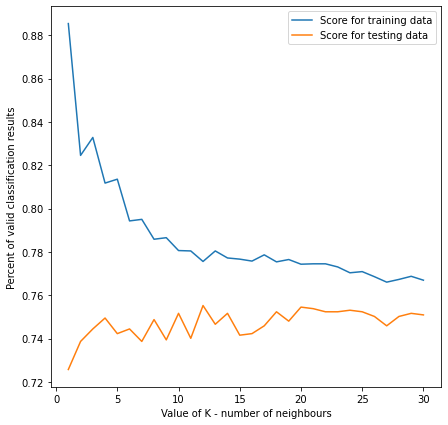

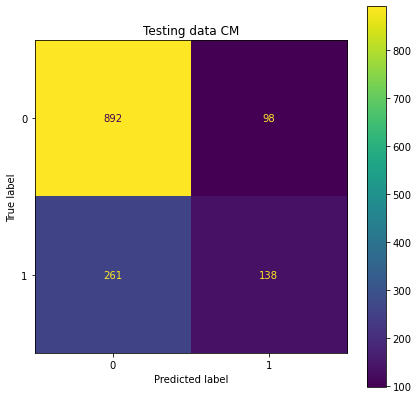

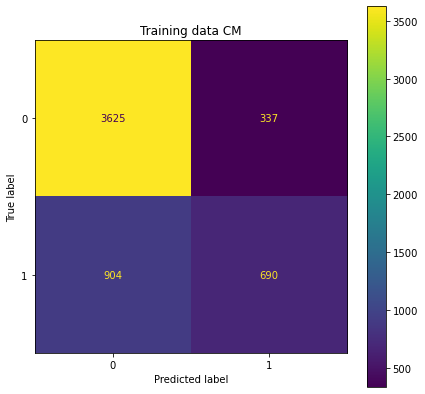

In [10]:
k_neighbours_full_classification_test(training_data, testing_data, training_columns)

### Perform classification using decision tree

Max depth = 1 - test data score: 0.7566594672426206, training data score: 0.7528797696184305
Max depth = 2 - test data score: 0.7566594672426206, training data score: 0.7528797696184305
Max depth = 3 - test data score: 0.7566594672426206, training data score: 0.7528797696184305
Max depth = 4 - test data score: 0.761699064074874, training data score: 0.7580993520518359
Max depth = 5 - test data score: 0.7494600431965442, training data score: 0.7629589632829373
Max depth = 6 - test data score: 0.7437005039596832, training data score: 0.771598272138229
Max depth = 7 - test data score: 0.7429805615550756, training data score: 0.7802375809935205
Max depth = 8 - test data score: 0.7487401007919366, training data score: 0.7935565154787617
Max depth = 9 - test data score: 0.7537796976241901, training data score: 0.802735781137509
Max depth = 10 - test data score: 0.7523398128149748, training data score: 0.8149748020158387

Using decision tree with max depth=3 to perform in-depth tests:
Accurac

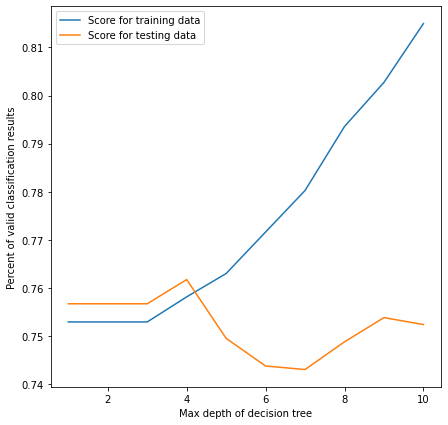

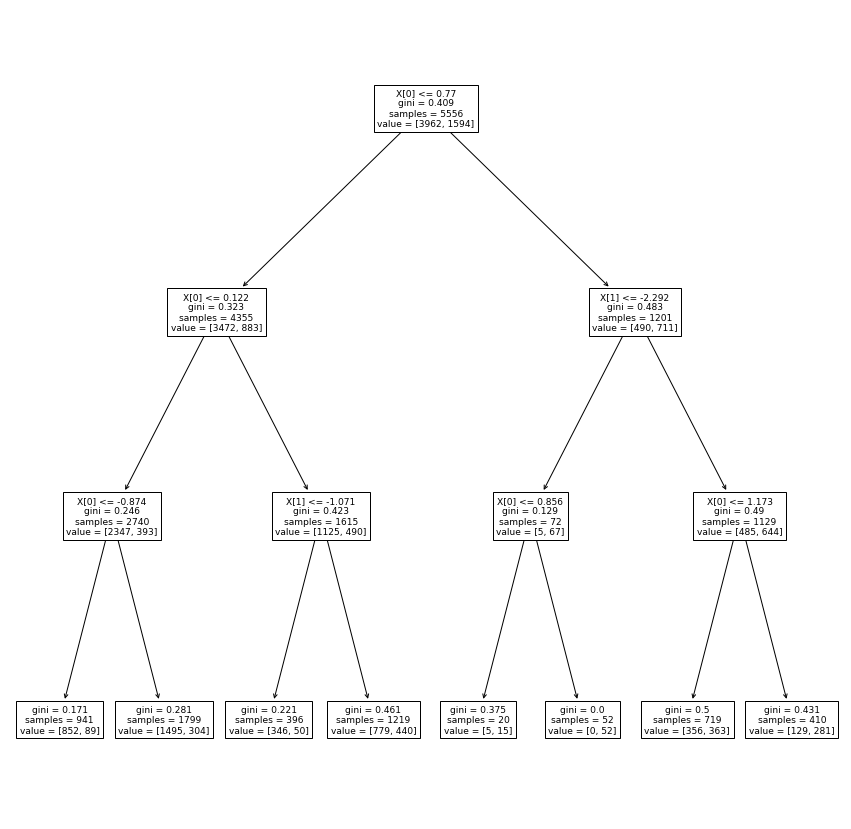

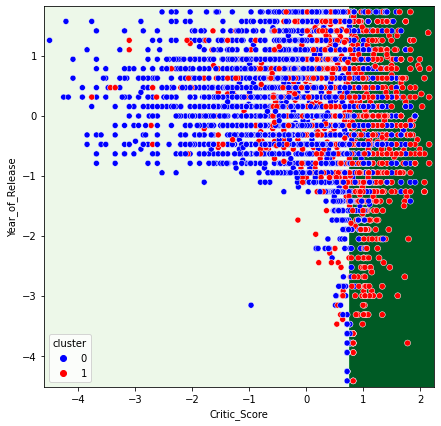

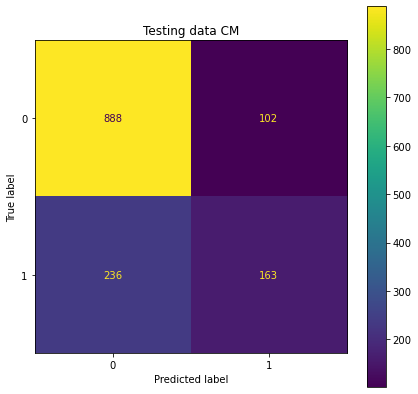

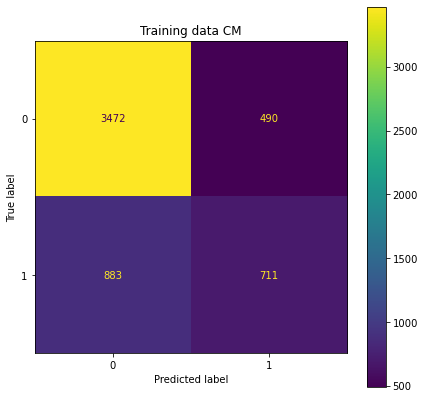

In [11]:
decision_tree_full_classification_test(training_data, testing_data, training_columns, palette)

### Perform classification using kernel density estimators

Bandwidth for class 0: 0.12618568830660204
Bandwidth for class 1: 0.17475284000076838
Total number of training samples: 5556
Number of training samples in class 0: 3962
Number of training samples in class 1: 1594
KDE classification - training data:
Classification accuracy: 0.7670986321094313
KDE classification - testing data:
Classification accuracy: 0.761699064074874


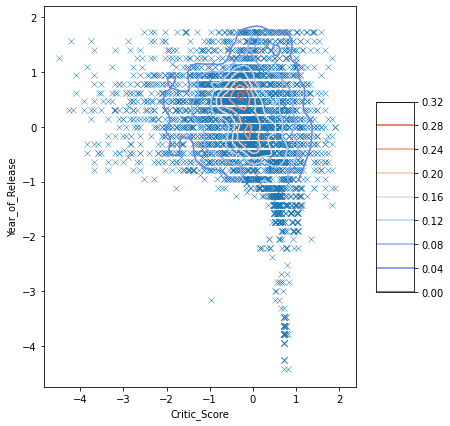

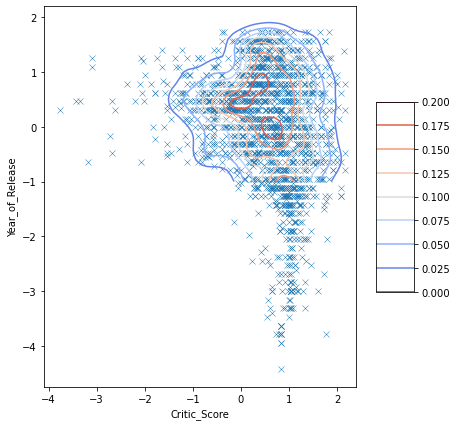

0.761699064074874

In [12]:
# use cross-validation to get proper bandwidths, plot KDEs
# they should be about: 0.126 and 0.175
bandwidths_for_classes = []
for cl in range(0, 2):
    bandwidth_for_given_class = compute_bandwidth_for_kernel_density_estimator(training_data, training_columns, cl)
    bandwidths_for_classes.append(bandwidth_for_given_class)
    print("Bandwidth for class {}: {}".format(cl, bandwidth_for_given_class))
    plot_kernel_density_estimator(training_data, training_columns, cl, bandwidth_for_given_class)

# get members count for each class
cl0_count = training_data[training_data["cluster"] == 0].shape[0]
cl1_count = training_data[training_data["cluster"] == 1].shape[0]

# prepare KDE objects
tr_data_cl0 = training_data[training_data["cluster"] == 0]
kde_cl0 = KernelDensity(bandwidth=bandwidths_for_classes[0], kernel="gaussian").fit(tr_data_cl0[training_columns])
tr_data_cl1 = training_data[training_data["cluster"] == 1]
kde_cl1 = KernelDensity(bandwidth=bandwidths_for_classes[1], kernel="gaussian").fit(tr_data_cl1[training_columns])

# print information about training data
print("Total number of training samples: {}".format(training_data.shape[0]))
print("Number of training samples in class 0: {}".format(cl0_count))
print("Number of training samples in class 1: {}".format(cl1_count))

# perform classification, display accuracy
print("KDE classification - training data:")
perform_classification_using_kernel_density_estimator(training_data, training_columns, [cl0_count, cl1_count], [kde_cl0, kde_cl1])
print("KDE classification - testing data:")
perform_classification_using_kernel_density_estimator(testing_data, training_columns, [cl0_count, cl1_count], [kde_cl0, kde_cl1])

## Global_Sales classification - 3 classes
Three classes will be used: global sales higher than 1 million, lower than 0.3 million and the rest.
Classification will be performed using Critic_Score and Year_of_Release.

### Data preparation

Number of entries in each cluster:
0    2574
1    2378
2    1993
Name: cluster, dtype: int64


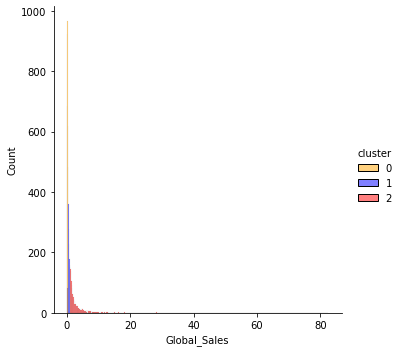

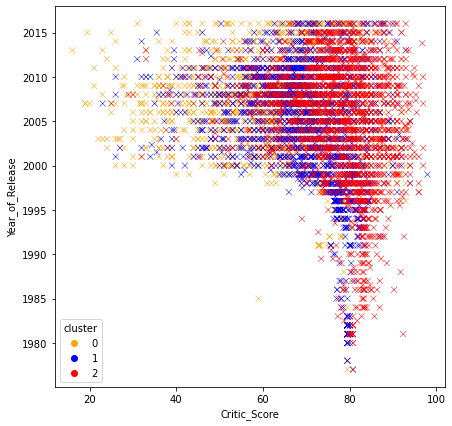

In [13]:
# filter used columns
used_columns = ["Critic_Score", "Year_of_Release", "Global_Sales"]
data = data_backup.filter(items=["Name", *used_columns])

# group by game name
data = data.groupby("Name").agg({"Critic_Score": np.mean, "Global_Sales": np.sum, "Year_of_Release": np.mean})\
    .reset_index().sort_values(by="Global_Sales").filter(items=used_columns)

# create artificial clusters - classes
data["cluster"] = 1
data.loc[data["Global_Sales"] < 0.3, "cluster"] = 0
data.loc[data["Global_Sales"] > 1, "cluster"] = 2

# print clusters sizes
print("Number of entries in each cluster:\n{}".format(data["cluster"].value_counts()))

# display density plot with classes
palette = ["orange", "blue", "red"]
sns.displot(data, x="Global_Sales", hue="cluster", palette=palette)
plt.show()

# display scatter plot with classes
sns.scatterplot(data=data, x="Critic_Score", y="Year_of_Release", hue="cluster", palette=palette, marker='x')
plt.show()

# standardize data
standardization = StandardScaler().fit(data[used_columns])
data[used_columns] = standardization.transform(data[used_columns])

# drop column with Global_Sales - it should not be used for the classification
data = data.drop(["Global_Sales"], axis=1)

### Split the dataset into training and testing parts for further studies

In [14]:
training_columns = ["Critic_Score", "Year_of_Release"]
training_data, testing_data = split_dataset_into_training_and_testing_parts(data, training_columns, 0.2)

### Perform classification using KNN

K = 1 - test data score: 0.49892008639308855, training data score: 0.7510799136069114
K = 2 - test data score: 0.4888408927285817, training data score: 0.6565874730021598
K = 3 - test data score: 0.5082793376529877, training data score: 0.6711663066954644
K = 4 - test data score: 0.5147588192944564, training data score: 0.646508279337653
K = 5 - test data score: 0.5125989920806335, training data score: 0.6297696184305256
K = 6 - test data score: 0.5046796256299496, training data score: 0.6220302375809935
K = 7 - test data score: 0.5075593952483801, training data score: 0.6202303815694744
K = 8 - test data score: 0.490280777537797, training data score: 0.6020518358531317
K = 9 - test data score: 0.5025197984161267, training data score: 0.5948524118070554
K = 10 - test data score: 0.4888408927285817, training data score: 0.5921526277897768
K = 11 - test data score: 0.49100071994240463, training data score: 0.5862131029517639
K = 12 - test data score: 0.48812095032397407, training data sc

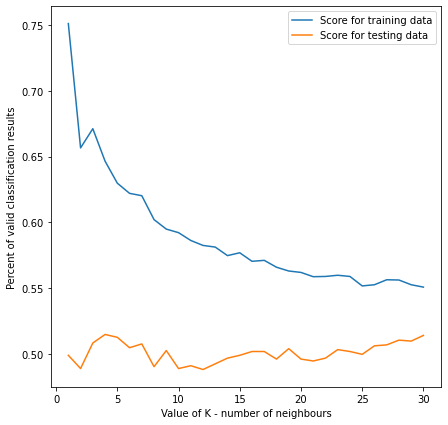

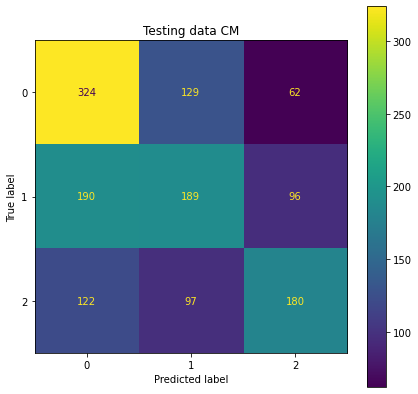

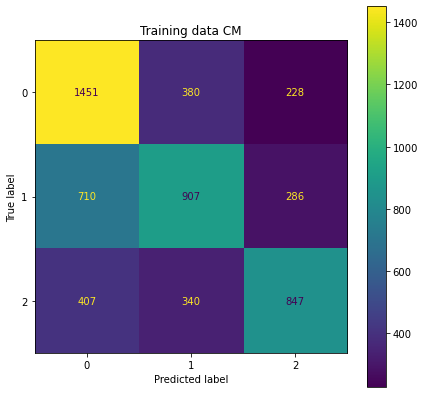

In [15]:
k_neighbours_full_classification_test(training_data, testing_data, training_columns)

### Perform classification using decision tree

Max depth = 1 - test data score: 0.45788336933045354, training data score: 0.4663426925845932
Max depth = 2 - test data score: 0.48524118070554356, training data score: 0.48758099352051837
Max depth = 3 - test data score: 0.4816414686825054, training data score: 0.4974802015838733
Max depth = 4 - test data score: 0.5068394528437725, training data score: 0.5046796256299496
Max depth = 5 - test data score: 0.5003599712023038, training data score: 0.5257379409647228
Max depth = 6 - test data score: 0.503959683225342, training data score: 0.5358171346292296
Max depth = 7 - test data score: 0.5017998560115191, training data score: 0.5496760259179265
Max depth = 8 - test data score: 0.5219582433405328, training data score: 0.5701943844492441
Max depth = 9 - test data score: 0.5248380129589633, training data score: 0.5863930885529157
Max depth = 10 - test data score: 0.5140388768898488, training data score: 0.6096112311015118

Using decision tree with max depth=3 to perform in-depth tests:
Ac

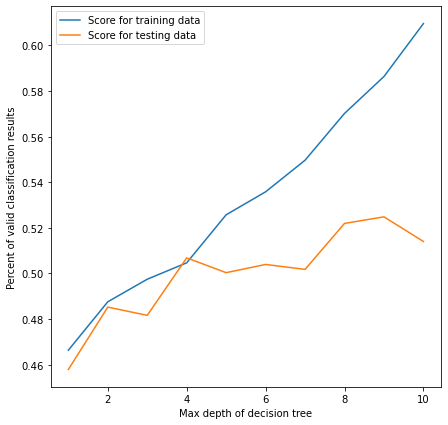

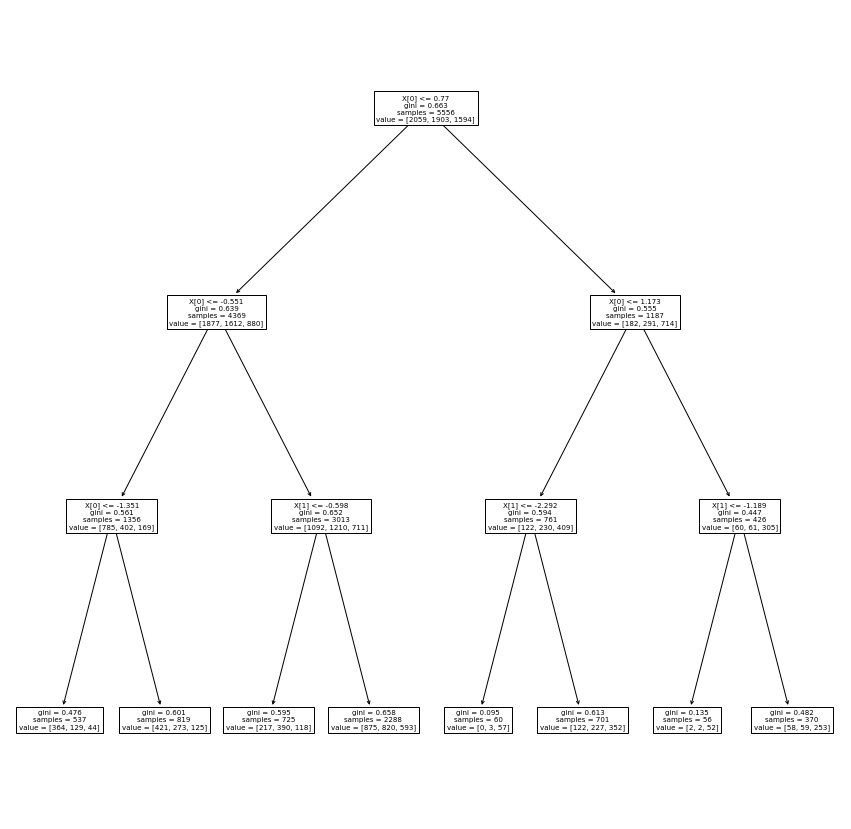

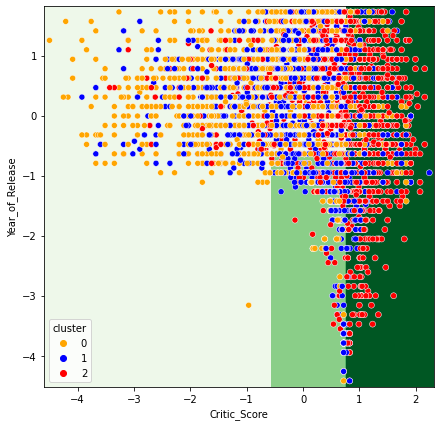

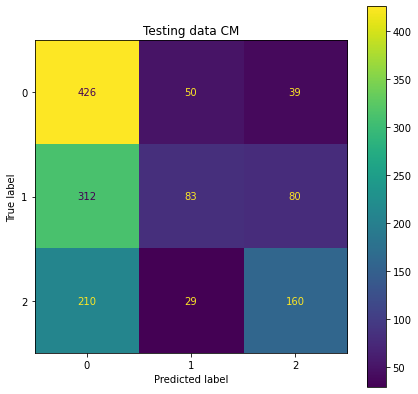

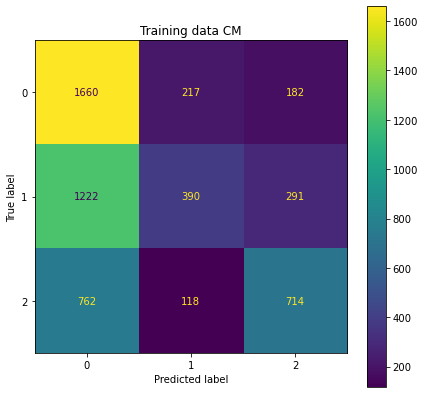

In [16]:
decision_tree_full_classification_test(training_data, testing_data, training_columns, palette)

### Perform classification using kernel density estimators

Bandwidth for class 0: 0.1592282793341092
Bandwidth for class 1: 0.12045035402587821
Bandwidth for class 2: 0.16681005372000587
Total number of training samples: 5556
Number of training samples in class 0: 2059
Number of training samples in class 1: 1903
Number of training samples in class 2: 1594
KDE classification - training data:
Classification accuracy: 0.5404967602591793
KDE classification - testing data:
Classification accuracy: 0.5046796256299496


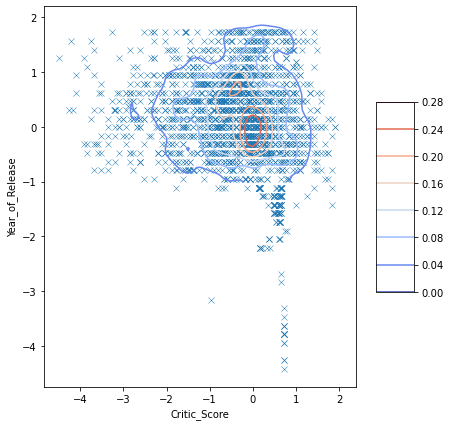

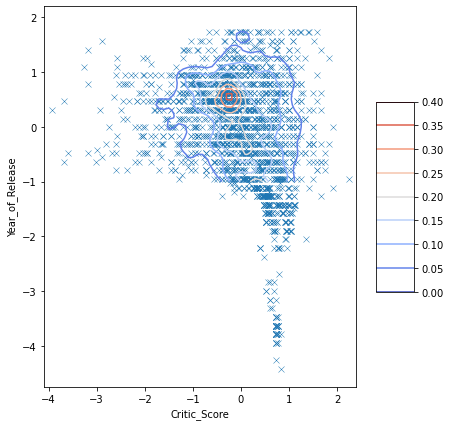

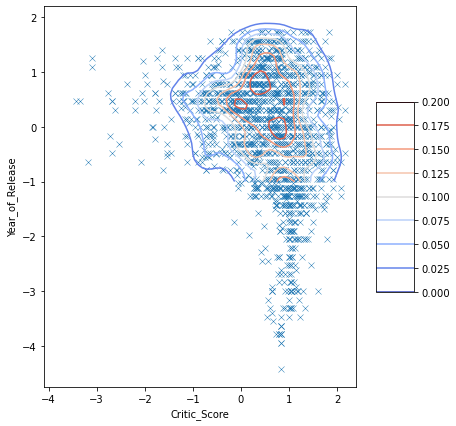

0.5046796256299496

In [17]:
# use cross-validation to get proper bandwidths, plot KDEs
# they should be about: 0.159, 0.126, 0.183
bandwidths_for_classes = []
for cl in range(0, 3):
    bandwidth_for_given_class = compute_bandwidth_for_kernel_density_estimator(training_data, training_columns, cl)
    bandwidths_for_classes.append(bandwidth_for_given_class)
    print("Bandwidth for class {}: {}".format(cl, bandwidth_for_given_class))
    plot_kernel_density_estimator(training_data, training_columns, cl, bandwidth_for_given_class)

# get members count for each class
cl0_count = training_data[training_data["cluster"] == 0].shape[0]
cl1_count = training_data[training_data["cluster"] == 1].shape[0]
cl2_count = training_data[training_data["cluster"] == 2].shape[0]

# prepare KDE objects
tr_data_cl0 = training_data[training_data["cluster"] == 0]
kde_cl0 = KernelDensity(bandwidth=bandwidths_for_classes[0], kernel="gaussian").fit(tr_data_cl0[training_columns])
tr_data_cl1 = training_data[training_data["cluster"] == 1]
kde_cl1 = KernelDensity(bandwidth=bandwidths_for_classes[1], kernel="gaussian").fit(tr_data_cl1[training_columns])
tr_data_cl2 = training_data[training_data["cluster"] == 2]
kde_cl2 = KernelDensity(bandwidth=bandwidths_for_classes[2], kernel="gaussian").fit(tr_data_cl2[training_columns])

# print information about training data
print("Total number of training samples: {}".format(training_data.shape[0]))
print("Number of training samples in class 0: {}".format(cl0_count))
print("Number of training samples in class 1: {}".format(cl1_count))
print("Number of training samples in class 2: {}".format(cl2_count))

# perform classification, display accuracy
print("KDE classification - training data:")
perform_classification_using_kernel_density_estimator(training_data, training_columns,
                                                      [cl0_count, cl1_count, cl2_count], [kde_cl0, kde_cl1, kde_cl2])
print("KDE classification - testing data:")
perform_classification_using_kernel_density_estimator(testing_data, training_columns,
                                                      [cl0_count, cl1_count, cl2_count], [kde_cl0, kde_cl1, kde_cl2])